In [16]:
# # edu_qgc_cora_pca_ego_fixed.py
# # -*- coding: utf-8 -*-
# """
# EDU-QGC Node Classification on Cora ego-graphs (20 nodes, PCA->10 feats, 3 labels)
# - Strict reproducibility (per PyTorch randomness notes)
# - Dataset saved to disk for reuse
# - Model kept identical; only dataset pipeline replaced/fixed
# """

# import os
# # --- MUST be set BEFORE importing torch to enable deterministic cuBLAS operations ---
# os.environ.setdefault("CUBLAS_WORKSPACE_CONFIG", ":4096:8")

# import sys
# import math
# import random
# import pickle
# from pathlib import Path
# from datetime import datetime

# import numpy as np

# # Torch AFTER setting env var above
# import torch
# import torch.nn.functional as F
# from torch import nn

# import networkx as nx
# import matplotlib.pyplot as plt
# import pennylane as qml

# # PyG + sklearn
# try:
#     from torch_geometric.datasets import Planetoid
#     import torch_geometric.utils as pyg_utils
# except Exception as e:
#     raise RuntimeError(
#         "This script needs PyTorch Geometric. Install it with:\n"
#         "  pip install torch-geometric\n"
#         "and follow the platform-specific instructions from https://pytorch-geometric.readthedocs.io/ ."
#     )

# from sklearn.decomposition import PCA

# # =========================================================
# # Reproducibility helper
# # =========================================================
# def set_global_determinism(seed: int):
#     """
#     Set seeds and flags to make experiments reproducible.
#     Requires CUBLAS_WORKSPACE_CONFIG to be set before torch import (done at top).
#     """
#     os.environ["PYTHONHASHSEED"] = str(seed)
#     random.seed(seed)
#     np.random.seed(seed)

#     torch.manual_seed(seed)
#     if torch.cuda.is_available():
#         torch.cuda.manual_seed_all(seed)

#     # Enable deterministic algorithms; will error if an op is non-deterministic
#     torch.use_deterministic_algorithms(True)
#     torch.backends.cudnn.deterministic = True
#     torch.backends.cudnn.benchmark = False


# # =========================================================
# # Small utils
# # =========================================================
# def confusion_matrix(y_true, y_pred, num_classes=2):
#     cm = np.zeros((num_classes, num_classes), dtype=int)
#     for t, p in zip(y_true, y_pred):
#         cm[int(t), int(p)] += 1
#     return cm

# def macro_accuracy(y_true, y_pred, num_classes=2):
#     cm = confusion_matrix(y_true, y_pred, num_classes=num_classes)
#     per_class = []
#     for c in range(num_classes):
#         support = cm[c, :].sum()
#         correct = cm[c, c]
#         acc_c = correct / support if support > 0 else 0.0
#         per_class.append(acc_c)
#     return float(np.mean(per_class))

# def print_confusion(cm):
#     num_classes = cm.shape[0]
#     print("Confusion matrix (rows=true, cols=pred):")
#     for i in range(num_classes):
#         row = " ".join(f"{cm[i, j]:4d}" for j in range(num_classes))
#         print(f"class {i}: {row}")


# # =========================================================
# # Fixed EDU-QGC model (unchanged)
# # =========================================================
# class EDUQGCNodeClassifier(nn.Module):
#     """
#     Same model you already use; unchanged. Equivariant QGC with shared parameters.
#     """
#     def __init__(self, n_nodes, in_feats=10, T=2, seed=0, use_gpu_qnode=True, use_feat_skip=True):
#         super().__init__()
#         self.n_nodes = n_nodes
#         self.T = T
#         self.use_feat_skip = use_feat_skip

#         # Parameters
#         self.enc_W = nn.Parameter(torch.randn(T, 2, in_feats) * 0.08)  # [T,2,F]
#         self.enc_b = nn.Parameter(torch.randn(T, 2) * 0.02)           # [T,2]

#         self.edge_phase  = nn.Parameter(torch.randn(T) * 0.08)
#         self.pre_theta   = nn.Parameter(torch.randn(T) * 0.08)
#         self.pre_psi     = nn.Parameter(torch.randn(T) * 0.08)
#         self.post_theta  = nn.Parameter(torch.randn(T) * 0.08)
#         self.post_psi    = nn.Parameter(torch.randn(T) * 0.08)

#         readin_dim = 1 + in_feats if use_feat_skip else 1
#         self.readout = nn.Linear(readin_dim, 3)  # 3 labels subset

#         use_cuda = torch.cuda.is_available()
#         qdev_name = "lightning.gpu" if (use_gpu_qnode and use_cuda) else "default.qubit"
#         self.dev = qml.device(qdev_name, wires=n_nodes, shots=None)

#         @qml.qnode(self.dev, interface="torch", diff_method="best")
#         def circuit(edge_index, X, enc_W, enc_b,
#                     edge_phase, pre_theta, pre_psi, post_theta, post_psi):
#             # Loop layers
#             for t in range(self.T):
#                 enc_out = X @ enc_W[t].T + enc_b[t]  # [N,2]
#                 alphas = enc_out[:, 0]; betas = enc_out[:, 1]
#                 for i in range(self.n_nodes):
#                     qml.RX(alphas[i], wires=i)
#                     qml.RY(betas[i], wires=i)

#                 for i in range(self.n_nodes):
#                     qml.RZ(pre_psi[t], wires=i)
#                     qml.RX(pre_theta[t], wires=i)

#                 # entanglers
#                 E = edge_index.shape[1]
#                 for e in range(E):
#                     u = int(edge_index[0, e].item()); v = int(edge_index[1, e].item())
#                     if u != v:
#                         qml.ControlledPhaseShift(edge_phase[t], wires=[u, v])

#                 for i in range(self.n_nodes):
#                     qml.RZ(post_psi[t], wires=i)
#                     qml.RX(post_theta[t], wires=i)

#             return [qml.expval(qml.Z(i)) for i in range(self.n_nodes)]

#         self._circuit = circuit

#     def forward(self, edge_index_torch, x_torch):
#         model_device = next(self.parameters()).device
#         edge_index = edge_index_torch.to(model_device)
#         X = x_torch.to(model_device).float()

#         out = self._circuit(edge_index, X,
#                             self.enc_W, self.enc_b,
#                             self.edge_phase,
#                             self.pre_theta, self.pre_psi,
#                             self.post_theta, self.post_psi)

#         expvals = torch.stack(out, dim=0).float().to(model_device)
#         if expvals.dim() == 1:
#             expvals = expvals.unsqueeze(1)
#         elif expvals.dim() == 2 and expvals.shape[1] == 1:
#             pass
#         else:
#             expvals = expvals.squeeze(-1).unsqueeze(1)

#         readin = torch.cat([expvals, X], dim=1) if self.use_feat_skip else expvals
#         logits = self.readout(readin)
#         return logits


# # =========================================================
# # Dataset: Cora → k-hop ego-graphs → enforce 20 nodes → PCA to 10 feats → 3 labels
# # =========================================================
# def build_cora_ego_dataset(
#     num_graphs=45,
#     chosen_labels=(0, 1, 2),
#     n_hops_initial=2,
#     target_nodes=20,
#     pca_dim=10,
#     seed=42,
#     save_path="./data/cora_ego20_pca10_lbl012_seed{seed}.pkl"
# ):
#     """
#     Returns a list of dicts: {edge_index [2,E], X [20,10], y [20]}
#     - Only nodes with labels in chosen_labels are eligible as centers
#     - Each subgraph has exactly 20 nodes; we grow hops up to 3; if still short, we pad with extra eligible nodes
#     - PCA fit is done on ALL eligible nodes' original features for stability, then applied to each subgraph
#     - Edges remapped to contiguous 0..19, undirected (both directions)
#     - If no edges remain, we add self-loops to keep circuit valid
#     """
#     rng = np.random.default_rng(seed)

#     # Load Cora
#     dataset = Planetoid(root="./data/pyg_cora", name="Cora")
#     data = dataset[0]  # single-graph
#     x_all = data.x.numpy().astype(np.float32)           # [2708, 1433]
#     y_all = data.y.numpy().astype(np.int64)             # [2708]
#     edge_index_all = data.edge_index.numpy()            # [2, E_all], 0-based

#     # Eligible nodes by label subset
#     chosen_labels_set = set(chosen_labels)
#     eligible = np.array([i for i, y in enumerate(y_all) if y in chosen_labels_set], dtype=np.int64)
#     if len(eligible) == 0:
#         raise RuntimeError("No nodes match the chosen_labels in Cora.")

#     # Fit PCA on ALL eligible nodes (full original feature space)
#     pca = PCA(n_components=pca_dim, random_state=seed)
#     pca.fit(x_all[eligible])

#     # Helper: build ego graph growing hops up to max 3 if needed
#     def pick_subgraph(center_id):
#         # Start from initial hops
#         hops = n_hops_initial
#         nodes = None
#         for attempt in range(2):  # try initial hops, then hops+1 if needed
#             nodes_t = pyg_utils.k_hop_subgraph(
#                 center_id, hops, torch.as_tensor(edge_index_all, dtype=torch.long), relabel_nodes=False
#             )[0].numpy()
#             if len(nodes_t) >= target_nodes:
#                 nodes = nodes_t
#                 break
#             hops += 1  # grow
#         if nodes is None:
#             nodes = nodes_t  # whatever we got after attempts

#         # Only keep nodes with chosen labels
#         nodes = np.array([n for n in nodes if y_all[n] in chosen_labels_set], dtype=np.int64)

#         # If still short, pad with additional eligible nodes
#         unique_nodes = set(nodes.tolist())
#         if len(unique_nodes) < target_nodes:
#             candidates = [n for n in eligible if n not in unique_nodes]
#             rng.shuffle(candidates)
#             need = target_nodes - len(unique_nodes)
#             add = candidates[:need] if len(candidates) >= need else candidates
#             nodes = np.array(list(unique_nodes) + add, dtype=np.int64)

#         # If oversize, downsample
#         if len(nodes) > target_nodes:
#             rng.shuffle(nodes)
#             nodes = nodes[:target_nodes]

#         assert len(nodes) == target_nodes, f"Subgraph size {len(nodes)} != {target_nodes}"
#         nodes = np.array(nodes, dtype=np.int64)

#         # --- induced edges ---
#         node_set = set(nodes.tolist())
#         mask = np.array([(u in node_set) and (v in node_set) for u, v in zip(edge_index_all[0], edge_index_all[1])])
#         sub_edges = edge_index_all[:, mask]

#         relabel = {old: new for new, old in enumerate(nodes)}
#         if sub_edges.size > 0:
#             remapped = np.array([[relabel[int(u)], relabel[int(v)]] for u, v in sub_edges.T], dtype=np.int64).T
#         else:
#             remapped = np.zeros((2, 0), dtype=np.int64)

#         # Undirected, dedup
#         if remapped.shape[1] > 0:
#             edges = set()
#             for u, v in remapped.T:
#                 edges.add((u, v)); edges.add((v, u))
#             u_list, v_list = zip(*sorted(edges))
#             edge_index = np.vstack([u_list, v_list]).astype(np.int64)
#         else:
#             edge_index = np.vstack([np.arange(target_nodes), np.arange(target_nodes)])

#         # PCA compress features
#         X_raw = x_all[nodes]
#         X_sub = pca.transform(X_raw).astype(np.float32)

#         # Map labels safely
#         y_sub_orig = y_all[nodes]
#         label_map = {old: new for new, old in enumerate(chosen_labels)}
#         y_sub = np.array([label_map[int(lbl)] for lbl in y_sub_orig], dtype=np.int64)

#         return dict(edge_index=edge_index, X=X_sub, y=y_sub)


#     # Deterministic center selection from eligible nodes
#     rng.shuffle(eligible)
#     centers = eligible[:num_graphs] if len(eligible) >= num_graphs else np.resize(eligible, num_graphs)

#     graphs = []
#     for c in centers:
#         graphs.append(pick_subgraph(int(c)))

#     # Save dataset
#     save_path = Path(save_path.format(seed=seed))
#     save_path.parent.mkdir(parents=True, exist_ok=True)
#     with open(save_path, "wb") as f:
#         pickle.dump(dict(
#             graphs=graphs,
#             meta=dict(
#                 dataset="Cora",
#                 chosen_labels=tuple(chosen_labels),
#                 n_nodes=target_nodes,
#                 pca_dim=pca_dim,
#                 seed=seed
#             )
#         ), f)
#     print(f"[dataset saved] {save_path.resolve()}  (graphs={len(graphs)})")

#     return graphs, save_path


# def load_saved_dataset(path: str):
#     path = Path(path)
#     with open(path, "rb") as f:
#         payload = pickle.load(f)
#     return payload["graphs"], payload.get("meta", {})


# # =========================================================
# # Train / Eval
# # =========================================================
# def train_epoch(model, graphs, optimizer, device="cpu"):
#     model.train()
#     total_loss = 0.0; total_nodes = 0
#     for g in graphs:
#         edge_index = torch.from_numpy(g["edge_index"]).long().to(device)
#         X = torch.from_numpy(g["X"]).float().to(device)
#         y = torch.from_numpy(g["y"]).long().to(device)

#         logits = model(edge_index, X)
#         loss = F.cross_entropy(logits, y)

#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

#         total_loss += loss.item() * X.shape[0]
#         total_nodes += X.shape[0]
#     return total_loss / max(1, total_nodes)

# @torch.no_grad()
# def evaluate(model, graphs, device="cpu", num_classes=3):
#     model.eval()
#     all_true, all_pred = [], []
#     total_loss, total_nodes = 0.0, 0
#     for g in graphs:
#         edge_index = torch.from_numpy(g["edge_index"]).long().to(device)
#         X = torch.from_numpy(g["X"]).float().to(device)
#         y = torch.from_numpy(g["y"]).long().to(device)

#         logits = model(edge_index, X)
#         loss = F.cross_entropy(logits, y)

#         pred = logits.argmax(dim=1).cpu().numpy()
#         all_pred.extend(pred)
#         all_true.extend(list(y.cpu().numpy()))

#         total_loss += loss.item() * X.shape[0]
#         total_nodes += X.shape[0]

#     avg_loss = total_loss / max(1, total_nodes)
#     all_true = np.array(all_true); all_pred = np.array(all_pred)
#     mac_acc = macro_accuracy(all_true, all_pred, num_classes=num_classes)
#     cm = confusion_matrix(all_true, all_pred, num_classes=num_classes)
#     return avg_loss, mac_acc, cm, all_true, all_pred


# def train_val_test_split_graphs(num_graphs, splits=(0.6, 0.2, 0.2), seed=0):
#     idx = np.arange(num_graphs)
#     rng = np.random.default_rng(seed)
#     rng.shuffle(idx)
#     n_train = int(splits[0] * num_graphs)
#     n_val = int(splits[1] * num_graphs)
#     train_idx = idx[:n_train]
#     val_idx = idx[n_train:n_train + n_val]
#     test_idx = idx[n_train + n_val:]
#     return train_idx, val_idx, test_idx


# # =========================================================
# # Runner
# # =========================================================
# def run_experiment(
#     num_graphs=45,
#     splits=(0.6, 0.2, 0.2),
#     T=2,
#     epochs=30,
#     lr=0.03,
#     seed=42,
#     device="cuda",
#     use_gpu_qnode=True,
#     dataset_path="./data/cora_ego20_pca10_lbl012_seed{seed}.pkl"
# ):
#     # Strict reproducibility
#     set_global_determinism(seed)
#     print("[repro] seed:", seed)
#     print("[repro] deterministic:", torch.are_deterministic_algorithms_enabled())
#     print("[repro] cudnn.deterministic:", torch.backends.cudnn.deterministic)
#     print("[repro] cudnn.benchmark:", torch.backends.cudnn.benchmark)
#     print("[repro] CUBLAS_WORKSPACE_CONFIG:", os.environ.get("CUBLAS_WORKSPACE_CONFIG"))

#     # Build/load dataset
#     ds_path = Path(dataset_path.format(seed=seed))
#     if ds_path.exists():
#         graphs, meta = load_saved_dataset(ds_path)
#         print(f"[dataset loaded] {ds_path.resolve()} | meta={meta}")
#         if len(graphs) < num_graphs:
#             print(f"[warn] saved dataset has {len(graphs)} < requested {num_graphs}; will reuse first {len(graphs)}.")
#             num_graphs = len(graphs)
#     else:
#         graphs, _ = build_cora_ego_dataset(
#             num_graphs=num_graphs,
#             chosen_labels=(0,1,2),
#             n_hops_initial=2,
#             target_nodes=20,
#             pca_dim=10,
#             seed=seed,
#             save_path=str(ds_path)
#         )

#     # Restrict to requested count deterministically
#     graphs = graphs[:num_graphs]

#     # Splits
#     train_idx, val_idx, test_idx = train_val_test_split_graphs(num_graphs, splits=splits, seed=seed)
#     train_graphs = [graphs[i] for i in train_idx]
#     val_graphs   = [graphs[i] for i in val_idx]
#     test_graphs  = [graphs[i] for i in test_idx]

#     # Model (unchanged)
#     N = 20
#     F_in = 10
#     NUM_CLASSES = 3
#     device = device if (device == "cpu" or torch.cuda.is_available()) else "cpu"
#     device = torch.device(device)

#     model = EDUQGCNodeClassifier(
#         n_nodes=N, in_feats=F_in, T=T, seed=seed, use_gpu_qnode=use_gpu_qnode, use_feat_skip=True
#     ).to(device)

#     opt = torch.optim.Adam(model.parameters(), lr=lr)

#     # Train
#     history = {"train_loss": [], "val_loss": [], "val_acc": []}
#     best_val = (-1.0, None)
#     for ep in range(1, epochs + 1):
#         tr_loss = train_epoch(model, train_graphs, opt, device=device)
#         val_loss, val_mac, val_cm, _, _ = evaluate(model, val_graphs, device=device, num_classes=NUM_CLASSES)

#         print(f"Epoch {ep:03d} | train_loss={tr_loss:.4f} | val_loss={val_loss:.4f} | val_macro_acc={val_mac:.3f}")

#         history["train_loss"].append(tr_loss)
#         history["val_loss"].append(val_loss)
#         history["val_acc"].append(val_mac)

#         if val_mac > best_val[0]:
#             best_val = (val_mac, {k: v.detach().cpu().clone() for k, v in model.state_dict().items()})

#     # Load best
#     if best_val[1] is not None:
#         model.load_state_dict(best_val[1])

#     # Final eval
#     tr_loss, tr_mac, tr_cm, tr_y, tr_pred = evaluate(model, train_graphs, device=device, num_classes=NUM_CLASSES)
#     va_loss, va_mac, va_cm, va_y, va_pred = evaluate(model, val_graphs, device=device, num_classes=NUM_CLASSES)
#     te_loss, te_mac, te_cm, te_y, te_pred = evaluate(model, test_graphs, device=device, num_classes=NUM_CLASSES)

#     print("\nResults:")
#     print(f"- Train: macro-acc={tr_mac:.3f}, loss={tr_loss:.4f}")
#     print_confusion(tr_cm)
#     print(f"- Val:   macro-acc={va_mac:.3f}, loss={va_loss:.4f}")
#     print_confusion(va_cm)
#     print(f"- Test:  macro-acc={te_mac:.3f}, loss={te_loss:.4f}")
#     print_confusion(te_cm)

#     # Save model + curves
#     out_dir = Path("outputs"); out_dir.mkdir(exist_ok=True, parents=True)
#     ts = datetime.now().strftime("%Y%m%d-%H%M%S")
#     model_path = out_dir / f"eduqgc_model_cora_seed{seed}_{ts}.pt"
#     torch.save(model.state_dict(), model_path)
#     print(f"[saved model] {model_path.resolve()}")

#     fig, ax = plt.subplots(1, 2, figsize=(12,4))
#     ax[0].plot(history["train_loss"], label="train loss")
#     ax[0].plot(history["val_loss"], label="val loss")
#     ax[0].set_xlabel("epoch"); ax[0].set_ylabel("loss"); ax[0].legend(); ax[0].set_title("Loss")

#     ax[1].plot(history["val_acc"], label="val macro-acc")
#     ax[1].set_xlabel("epoch"); ax[1].set_ylabel("macro-accuracy"); ax[1].legend(); ax[1].set_title("Validation Macro-Accuracy")
#     plt.tight_layout()
#     plt.savefig(out_dir / f"curves_cora_seed{seed}_{ts}.png", dpi=200)
#     plt.show()

#     return {
#         "model": model,
#         "splits": (train_idx, val_idx, test_idx),
#         "history": history,
#         "metrics": {
#             "train": dict(loss=tr_loss, macro_acc=tr_mac, cm=tr_cm, y=tr_y, pred=tr_pred),
#             "val":   dict(loss=va_loss, macro_acc=va_mac, cm=va_cm, y=va_y, pred=va_pred),
#             "test":  dict(loss=te_loss, macro_acc=te_mac, cm=te_cm, y=te_y, pred=te_pred),
#         },
#         "model_path": str(model_path.resolve()),
#         "dataset_path": str(Path("./data/cora_ego20_pca10_lbl012_seed{seed}.pkl".format(seed=seed)).resolve())
#     }


# # =========================================================
# # Main
# # =========================================================
# if __name__ == "__main__":
#     SEED = 42
#     DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
#     USE_GPU_QNODE = True  # requires pennylane-lightning[gpu]
#     NUM_GRAPHS = 45

#     results = run_experiment(
#         num_graphs=NUM_GRAPHS,
#         T=2,
#         epochs=30,
#         lr=0.03,
#         seed=SEED,
#         device=DEVICE,
#         use_gpu_qnode=USE_GPU_QNODE,
#         dataset_path="./data/cora_ego20_pca10_lbl012_seed{seed}.pkl"
#     )
#     print("Done. Results keys:", list(results.keys()))


In [17]:
# import networkx as nx
# import matplotlib.pyplot as plt
# import numpy as np

# def visualize_graph(gdict, idx=0, label_names=None):
#     """
#     Visualize a single graph from the dataset.
#     gdict : dict with keys 'edge_index', 'X', 'y'
#     """
#     edge_index = gdict["edge_index"]
#     y = gdict["y"]

#     # Build networkx graph with true node IDs
#     G = nx.Graph()
#     for u, v in edge_index.T:
#         G.add_edge(int(u), int(v))

#     nodes = list(G.nodes())
#     num_nodes = len(nodes)

#     if len(y) != num_nodes:
#         print(f"[Warning] Graph {idx}: |y|={len(y)} != |nodes|={num_nodes}")
#         # Fallback: just trim or pad labels
#         if len(y) > num_nodes:
#             y = y[:num_nodes]
#         else:
#             y = np.pad(y, (0, num_nodes-len(y)), constant_values=-1)

#     # Build a dict {node_id : label}
#     label_map = {n: int(lbl) for n, lbl in zip(nodes, y)}

#     colors = [label_map[n] for n in nodes]
#     cmap = plt.get_cmap("Set1", len(set(colors)))


#     plt.figure(figsize=(4,4))
#     nx.draw(
#         G,
#         pos=nx.spring_layout(G, seed=42),
#         with_labels=True,
#         nodelist=nodes,
#         node_color=colors,
#         cmap=cmap,
#         node_size=500,
#         font_size=8,
#         font_color="white"
#     )

#     if label_names:
#         plt.title(f"Graph {idx} — Labels {[label_names[c] for c in set(y)]}")
#     else:
#         plt.title(f"Graph {idx} — Labels {set(y.tolist())}")
#     plt.show()


# def visualize_dataset(graphs, n_show=3):
#     """
#     Visualize first n_show graphs from dataset.
#     """
#     for i in range(min(n_show, len(graphs))):
#         visualize_graph(graphs[i], idx=i)


In [18]:
# graphs, _ = build_cora_ego_dataset(
#     num_graphs=5,
#     chosen_labels=(0,1,2),
#     target_nodes=20,
#     pca_dim=10,
#     seed=42
# )

# visualize_dataset(graphs, n_show=3)


Scaling study of EDU-QGC on Cora ego-graphs
Permutations over:
  - num_nodes in [20,25,30,35]
  - pca_dim   in [10,15,20,25]
Saves all datasets, models, and logs under ./cora_multi_exp/



In [19]:
# edu_qgc_cora_multi_exp.py
# -*- coding: utf-8 -*-
"""
Scaling study of EDU-QGC on Cora ego-graphs
Permutations over:
  - num_nodes in [20,25,30,35]
  - pca_dim   in [10,15,20,25]
Saves all datasets, models, and logs under ./cora_multi_exp/
"""

import os, sys, time, pickle, random, math
from pathlib import Path
from datetime import datetime
import itertools
import json

import numpy as np
import torch
import torch.nn.functional as F
from torch import nn
import matplotlib.pyplot as plt
import pennylane as qml
from sklearn.decomposition import PCA

# Torch Geometric
try:
    from torch_geometric.datasets import Planetoid
    import torch_geometric.utils as pyg_utils
except Exception as e:
    raise RuntimeError("Need torch-geometric installed.")

# =====================================================
# Utils for reproducibility
# =====================================================
def set_seed(seed=42):
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed); np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    torch.use_deterministic_algorithms(False)  # allow faster ops


# =====================================================
# Model (same as before, unchanged)
# =====================================================
class EDUQGCNodeClassifier(nn.Module):
    def __init__(self, n_nodes, in_feats, T=2, seed=0, use_gpu_qnode=True, use_feat_skip=True, num_classes=3):
        super().__init__()
        self.n_nodes = n_nodes
        self.T = T
        self.use_feat_skip = use_feat_skip

        self.enc_W = nn.Parameter(torch.randn(T, 2, in_feats) * 0.08)
        self.enc_b = nn.Parameter(torch.randn(T, 2) * 0.02)

        self.edge_phase  = nn.Parameter(torch.randn(T) * 0.08)
        self.pre_theta   = nn.Parameter(torch.randn(T) * 0.08)
        self.pre_psi     = nn.Parameter(torch.randn(T) * 0.08)
        self.post_theta  = nn.Parameter(torch.randn(T) * 0.08)
        self.post_psi    = nn.Parameter(torch.randn(T) * 0.08)

        readin_dim = 1 + in_feats if use_feat_skip else 1
        self.readout = nn.Linear(readin_dim, num_classes)

        use_cuda = torch.cuda.is_available()
        qdev_name = "lightning.gpu" if (use_gpu_qnode and use_cuda) else "default.qubit"
        self.dev = qml.device(qdev_name, wires=n_nodes, shots=None)

        @qml.qnode(self.dev, interface="torch", diff_method="best")
        def circuit(edge_index, X, enc_W, enc_b,
                    edge_phase, pre_theta, pre_psi, post_theta, post_psi):
            for t in range(self.T):
                enc_out = X @ enc_W[t].T + enc_b[t]
                alphas = enc_out[:, 0]; betas = enc_out[:, 1]
                for i in range(self.n_nodes):
                    qml.RX(alphas[i], wires=i)
                    qml.RY(betas[i], wires=i)

                for i in range(self.n_nodes):
                    qml.RZ(pre_psi[t], wires=i)
                    qml.RX(pre_theta[t], wires=i)

                E = edge_index.shape[1]
                for e in range(E):
                    u = int(edge_index[0, e].item()); v = int(edge_index[1, e].item())
                    if u != v:
                        qml.ControlledPhaseShift(edge_phase[t], wires=[u, v])

                for i in range(self.n_nodes):
                    qml.RZ(post_psi[t], wires=i)
                    qml.RX(post_theta[t], wires=i)

            return [qml.expval(qml.Z(i)) for i in range(self.n_nodes)]

        self._circuit = circuit

    def forward(self, edge_index_torch, x_torch):
        device = next(self.parameters()).device
        edge_index = edge_index_torch.to(device)
        X = x_torch.to(device).float()

        out = self._circuit(edge_index, X,
                            self.enc_W, self.enc_b,
                            self.edge_phase,
                            self.pre_theta, self.pre_psi,
                            self.post_theta, self.post_psi)

        expvals = torch.stack(out, dim=0).float().to(device)
        if expvals.dim() == 1:
            expvals = expvals.unsqueeze(1)
        elif expvals.dim() == 2 and expvals.shape[1] == 1:
            pass
        else:
            expvals = expvals.squeeze(-1).unsqueeze(1)

        readin = torch.cat([expvals, X], dim=1) if self.use_feat_skip else expvals
        logits = self.readout(readin)
        return logits


# =====================================================
# Dataset builder (same logic, adjustable N,F)
# =====================================================
def build_cora_ego_dataset(num_graphs=20, target_nodes=20, pca_dim=10,
                           chosen_labels=(0,1,2), seed=42, save_path=None):
    rng = np.random.default_rng(seed)
    dataset = Planetoid(root="./cora_multi_exp/raw", name="Cora")
    data = dataset[0]
    x_all = data.x.numpy().astype(np.float32)
    y_all = data.y.numpy().astype(np.int64)
    edge_index_all = data.edge_index.numpy()

    chosen_labels_set = set(chosen_labels)
    eligible = np.array([i for i,y in enumerate(y_all) if y in chosen_labels_set])
    pca = PCA(n_components=pca_dim, random_state=seed)
    pca.fit(x_all[eligible])

    def pick_subgraph(center):
        nodes = pyg_utils.k_hop_subgraph(
            torch.tensor([center], dtype=torch.long),
            2,
            torch.as_tensor(edge_index_all, dtype=torch.long),
            relabel_nodes=False
        )[0].numpy()

        nodes = np.array([n for n in nodes if y_all[n] in chosen_labels_set])
        unique = set(nodes.tolist())
        if len(unique) < target_nodes:
            extra = [n for n in eligible if n not in unique]
            rng.shuffle(extra)
            nodes = list(unique) + extra[:target_nodes-len(unique)]
        nodes = np.array(nodes[:target_nodes])

        relabel = {old:i for i,old in enumerate(nodes)}
        mask = [(u in relabel and v in relabel)
                for u,v in zip(edge_index_all[0], edge_index_all[1])]
        sub_edges = edge_index_all[:,mask]
        if sub_edges.size > 0:
            remapped = np.array([[relabel[int(u)], relabel[int(v)]]
                                 for u,v in sub_edges.T]).T
        else:
            remapped = np.zeros((2,0),dtype=int)
        edges = set()
        for u,v in remapped.T:
            edges.add((u,v)); edges.add((v,u))
        if len(edges)==0:
            edge_index = np.vstack([np.arange(target_nodes), np.arange(target_nodes)])
        else:
            u_list,v_list = zip(*edges)
            edge_index = np.vstack([u_list,v_list])
        X = pca.transform(x_all[nodes])
        y = np.array([ {old:i for i,old in enumerate(chosen_labels)}[int(lbl)]
                       for lbl in y_all[nodes]])
        return dict(edge_index=edge_index, X=X.astype(np.float32), y=y)

    rng.shuffle(eligible)
    centers = eligible[:num_graphs]
    graphs = [pick_subgraph(c) for c in centers]

    if save_path:
        Path(save_path).parent.mkdir(parents=True, exist_ok=True)
        with open(save_path,"wb") as f:
            pickle.dump(dict(graphs=graphs,meta=dict(N=target_nodes,F=pca_dim,seed=seed)),f)
    return graphs


# =====================================================
# Train/Eval helpers
# =====================================================
def train_epoch(model, graphs, opt, device="cpu"):
    model.train(); total_loss=0; nodes=0
    for g in graphs:
        e = torch.from_numpy(g["edge_index"]).long().to(device)
        X = torch.from_numpy(g["X"]).float().to(device)
        y = torch.from_numpy(g["y"]).long().to(device)
        logits = model(e,X)
        loss = F.cross_entropy(logits,y)
        opt.zero_grad(); loss.backward(); opt.step()
        total_loss += loss.item()*X.shape[0]; nodes+=X.shape[0]
    return total_loss/max(1,nodes)

@torch.no_grad()
def evaluate(model, graphs, device="cpu"):
    model.eval(); total_loss=0; nodes=0; correct=0
    for g in graphs:
        e = torch.from_numpy(g["edge_index"]).long().to(device)
        X = torch.from_numpy(g["X"]).float().to(device)
        y = torch.from_numpy(g["y"]).long().to(device)
        logits = model(e,X)
        loss = F.cross_entropy(logits,y)
        pred = logits.argmax(1)
        correct += (pred==y).sum().item()
        total_loss += loss.item()*X.shape[0]; nodes+=X.shape[0]
    return total_loss/max(1,nodes), correct/max(1,nodes)


# =====================================================
# Experiment Runner
# =====================================================
def run_scaling_experiments(N_list=[20,25,30,35], F_list=[10,15,20,25],
                            num_graphs=20, epochs=10, lr=0.03, seed=42,
                            base_dir="./cora_multi_exp"):
    set_seed(seed)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    results = []
    combos = list(itertools.product(N_list,F_list))
    print(f"[INFO] Running {len(combos)} experiments...")
    for N,F in combos:
        print(f"\n[Run] N={N}, F={F}")
        ds_path = Path(base_dir)/f"datasets/cora_N{N}_F{F}_seed{seed}.pkl"
        if ds_path.exists():
            with open(ds_path,"rb") as f: graphs=pickle.load(f)["graphs"]
        else:
            graphs=build_cora_ego_dataset(num_graphs=num_graphs,
                    target_nodes=N,pca_dim=F,seed=seed,save_path=ds_path)

        # simple split
        train, val, test = graphs[:int(0.6*num_graphs)], graphs[int(0.6*num_graphs):int(0.8*num_graphs)], graphs[int(0.8*num_graphs):]
        model = EDUQGCNodeClassifier(n_nodes=N,in_feats=F,num_classes=3).to(device)
        opt = torch.optim.Adam(model.parameters(), lr=lr)

        start = time.time()
        for ep in range(1,epochs+1):
            tr_loss = train_epoch(model,train,opt,device)
            val_loss,val_acc = evaluate(model,val,device)
            print(f"Epoch {ep:02d} | tr_loss={tr_loss:.3f} | val_loss={val_loss:.3f} | val_acc={val_acc:.3f}")
        end = time.time()

        te_loss, te_acc = evaluate(model,test,device)

        model_dir = Path(base_dir)/"models"; model_dir.mkdir(parents=True,exist_ok=True)
        model_path = model_dir/f"eduqgc_N{N}_F{F}_seed{seed}.pt"
        torch.save(model.state_dict(),model_path)

        results.append(dict(N=N,F=F,train_loss=tr_loss,val_loss=val_loss,
                            val_acc=val_acc,test_loss=te_loss,test_acc=te_acc,
                            time_sec=end-start,model_path=str(model_path),
                            dataset_path=str(ds_path)))
    # Save summary
    log_dir = Path(base_dir)/"logs"; log_dir.mkdir(parents=True,exist_ok=True)
    log_path = log_dir/f"scaling_results_seed{seed}.json"
    with open(log_path,"w") as f: json.dump(results,f,indent=2)
    print(f"\n[Summary saved] {log_path}")
    return results


if __name__=="__main__":
    run_scaling_experiments()


[INFO] Running 16 experiments...

[Run] N=20, F=10
Epoch 01 | tr_loss=0.953 | val_loss=0.804 | val_acc=0.688
Epoch 02 | tr_loss=0.661 | val_loss=0.634 | val_acc=0.738
Epoch 03 | tr_loss=0.508 | val_loss=0.540 | val_acc=0.812
Epoch 04 | tr_loss=0.423 | val_loss=0.486 | val_acc=0.812
Epoch 05 | tr_loss=0.376 | val_loss=0.449 | val_acc=0.838
Epoch 06 | tr_loss=0.346 | val_loss=0.419 | val_acc=0.850
Epoch 07 | tr_loss=0.327 | val_loss=0.394 | val_acc=0.863
Epoch 08 | tr_loss=0.312 | val_loss=0.375 | val_acc=0.863
Epoch 09 | tr_loss=0.300 | val_loss=0.349 | val_acc=0.875
Epoch 10 | tr_loss=0.288 | val_loss=0.327 | val_acc=0.887

[Run] N=20, F=15
Epoch 01 | tr_loss=0.927 | val_loss=0.785 | val_acc=0.725
Epoch 02 | tr_loss=0.620 | val_loss=0.639 | val_acc=0.762
Epoch 03 | tr_loss=0.479 | val_loss=0.528 | val_acc=0.787
Epoch 04 | tr_loss=0.398 | val_loss=0.475 | val_acc=0.812
Epoch 05 | tr_loss=0.351 | val_loss=0.443 | val_acc=0.838
Epoch 06 | tr_loss=0.323 | val_loss=0.415 | val_acc=0.825
Epo

LightningException: [/project/pennylane_lightning/core/utils/cuda_utils/DataBuffer.hpp][Line:68][Method:DataBuffer]: Error in PennyLane Lightning: out of memory

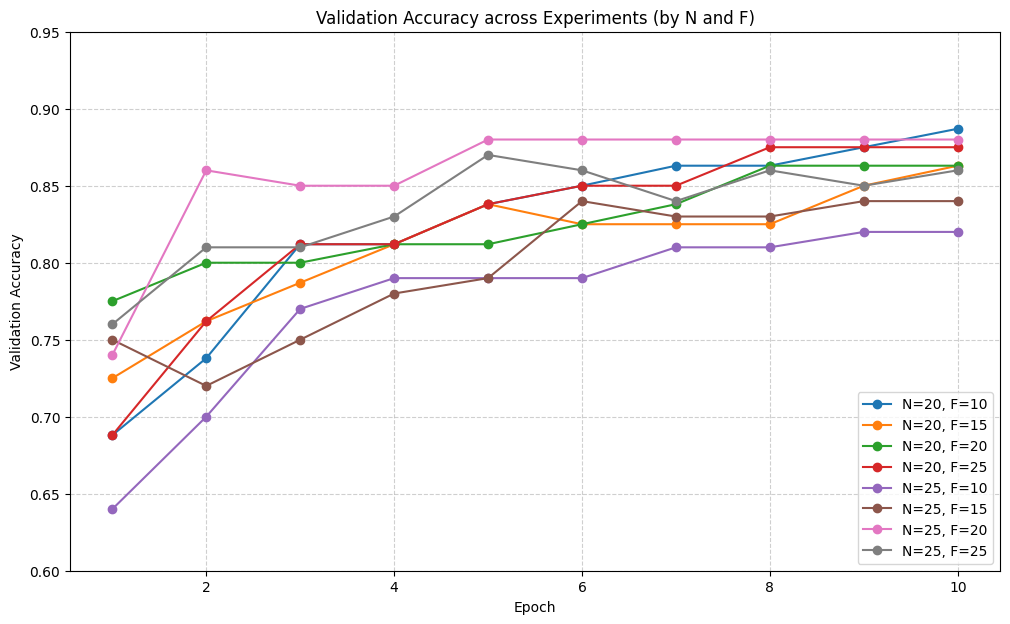

In [1]:
import matplotlib.pyplot as plt
import pandas as pd

# Store the experimental results into a DataFrame
data = [
    # N=20
    {"N":20,"F":10,"val_acc":[0.688,0.738,0.812,0.812,0.838,0.850,0.863,0.863,0.875,0.887]},
    {"N":20,"F":15,"val_acc":[0.725,0.762,0.787,0.812,0.838,0.825,0.825,0.825,0.850,0.863]},
    {"N":20,"F":20,"val_acc":[0.775,0.800,0.800,0.812,0.812,0.825,0.838,0.863,0.863,0.863]},
    {"N":20,"F":25,"val_acc":[0.688,0.762,0.812,0.812,0.838,0.850,0.850,0.875,0.875,0.875]},
    # N=25
    {"N":25,"F":10,"val_acc":[0.640,0.700,0.770,0.790,0.790,0.790,0.810,0.810,0.820,0.820]},
    {"N":25,"F":15,"val_acc":[0.750,0.720,0.750,0.780,0.790,0.840,0.830,0.830,0.840,0.840]},
    {"N":25,"F":20,"val_acc":[0.740,0.860,0.850,0.850,0.880,0.880,0.880,0.880,0.880,0.880]},
    {"N":25,"F":25,"val_acc":[0.760,0.810,0.810,0.830,0.870,0.860,0.840,0.860,0.850,0.860]},
]

# Convert to long DataFrame for plotting
records = []
for d in data:
    for epoch, acc in enumerate(d["val_acc"], start=1):
        records.append({"N":d["N"],"F":d["F"],"epoch":epoch,"val_acc":acc})

df = pd.DataFrame(records)

# Plot informative visualization
plt.figure(figsize=(12,7))

for (N,F), group in df.groupby(["N","F"]):
    plt.plot(group["epoch"], group["val_acc"], marker="o", label=f"N={N}, F={F}")

plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.title("Validation Accuracy across Experiments (by N and F)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.ylim(0.6, 0.95)
plt.show()
